# ISIC Competition Notebook

## Import Libraries

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.6 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Training Configuration

In [3]:
CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/efficientnet-timm/pytorch/default/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

### Set Seed

In [4]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

## Load the Dataset

In [5]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [6]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

### Read the Data

In [7]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [8]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print("        df.shape, # of positive cases, # of patients")
print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

        df.shape, # of positive cases, # of patients
original> (401059, 55) 393 (1042,)
filtered> (8253, 55) 393 (950,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,/kaggle/input/isic-2024-challenge/train-image/...
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/kaggle/input/isic-2024-challenge/train-image/...
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/kaggle/input/isic-2024-challenge/train-image/...
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,/kaggle/input/isic-2024-challenge/train-image/...
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,/kaggle/input/isic-2024-challenge/train-image/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8248,ISIC_0267522,0,IP_9577633,50.0,male,lower extremity,4.94,TBP tile: close-up,3D: XP,21.738880,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,96.325510,/kaggle/input/isic-2024-challenge/train-image/...
8249,ISIC_0267560,0,IP_7746572,80.0,male,anterior torso,9.32,TBP tile: close-up,3D: white,18.481750,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.022320,/kaggle/input/isic-2024-challenge/train-image/...
8250,ISIC_0267568,0,IP_0379091,60.0,male,anterior torso,3.45,TBP tile: close-up,3D: white,13.901465,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,72.961688,/kaggle/input/isic-2024-challenge/train-image/...
8251,ISIC_0267594,0,IP_1433033,70.0,NaN,lower extremity,3.00,TBP tile: close-up,3D: XP,17.986882,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.899274,/kaggle/input/isic-2024-challenge/train-image/...


In [9]:
df.shape[0], df.target.sum()

(8253, 393)

In [10]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

10316

## Preprocessing Classes

### Folds

In [11]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target,df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)

### Reduce the Amount of Negative Cases

In [12]:
df['target'].value_counts() # counts of positive (1) vs. negative (0) cases of skin cancer

target
0    7860
1     393
Name: count, dtype: int64

In [13]:
samples_to_drop = int((df['target'].value_counts()[0])*0.9)
df = df.drop(df[df['target']==0].sample(n=samples_to_drop).index)

df['target'].value_counts()

target
0    786
1    393
Name: count, dtype: int64

### DataSet

In [14]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }
    
class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

### Augmentations

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

### GeM Pooling

In [16]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

## Create Model

In [17]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output

    
model = ISICModel(CONFIG['model_name'], checkpoint_path=CONFIG['checkpoint_path'])
model.to(CONFIG['device']);

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

### Loss Function

In [18]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

### Training Function

In [19]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc

### Validation Function

In [20]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_auroc

## Run Training

In [21]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [22]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [23]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

### Prepare Dataloaders

In [24]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

### Define Optimizer and Scheduler

In [25]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

### Start Training

In [26]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: Tesla T4



100%|██████████| 4/4 [00:02<00:00,  1.78it/s, Epoch=1, LR=0.0001, Valid_Auroc=0.554, Valid_Loss=0.692]


Validation AUROC Improved (-inf ---> 0.5542341074360779)
Model Saved



100%|██████████| 4/4 [00:02<00:00,  1.85it/s, Epoch=2, LR=0.0001, Valid_Auroc=0.562, Valid_Loss=0.582]


Validation AUROC Improved (0.5542341074360779 ---> 0.5617405582922824)
Model Saved



100%|██████████| 4/4 [00:01<00:00,  2.66it/s, Epoch=3, LR=0.0001, Valid_Auroc=0.593, Valid_Loss=0.545]


Validation AUROC Improved (0.5617405582922824 ---> 0.5932676518883416)
Model Saved



100%|██████████| 4/4 [00:01<00:00,  2.61it/s, Epoch=4, LR=0.0001, Valid_Auroc=0.606, Valid_Loss=0.49] 


Validation AUROC Improved (0.5932676518883416 ---> 0.6064039408866995)
Model Saved



100%|██████████| 4/4 [00:01<00:00,  2.56it/s, Epoch=5, LR=0.0001, Valid_Auroc=0.6, Valid_Loss=0.522]  


100%|██████████| 4/4 [00:01<00:00,  2.68it/s, Epoch=6, LR=0.0001, Valid_Auroc=0.597, Valid_Loss=0.479]


100%|██████████| 4/4 [00:01<00:00,  2.55it/s, Epoch=7, LR=0.0001, Valid_Auroc=0.593, Valid_Loss=0.418]


100%|██████████| 4/4 [00:01<00:00,  2.61it/s, Epoch=8, LR=9.99e-5, Valid_Auroc=0.593, Valid_Loss=0.445]


100%|██████████| 4/4 [00:01<00:00,  2.61it/s, Epoch=9, LR=9.99e-5, Valid_Auroc=0.594, Valid_Loss=0.421]


100%|██████████| 4/4 [00:01<00:00,  2.59it/s, Epoch=10, LR=9.99e-5, Valid_Auroc=0.59, Valid_Loss=0.4]   


100%|██████████| 4/4 [00:01<00:00,  2.49it/s, Epoch=11, LR=9.99e-5, Valid_Auroc=0.596, Valid_Loss=0.441]


100%|██████████| 4/4 [00:01<00:00,  2.50it/s, Epoch=12, LR=9.99e-5, Valid_Auroc=0.592, Valid_Loss=0.394]


100%|██████████| 4/4 [00:01<00:00,  2.54it/s, Epoch=13, LR=9.99e-5, Valid_Auroc=0.59, Valid_Loss=0.48]  


100%|██████████| 4/4 [00:01<00:00,  2.59it/s, Epoch=14, LR=9.98e-5, Valid_Auroc=0.59, Valid_Loss=0.421] 


100%|██████████| 4/4 [00:01<00:00,  2.55it/s, Epoch=15, LR=9.98e-5, Valid_Auroc=0.588, Valid_Loss=0.417]


100%|██████████| 4/4 [00:01<00:00,  2.51it/s, Epoch=16, LR=9.98e-5, Valid_Auroc=0.597, Valid_Loss=0.425]


100%|██████████| 4/4 [00:01<00:00,  2.42it/s, Epoch=17, LR=9.98e-5, Valid_Auroc=0.599, Valid_Loss=0.45]


100%|██████████| 4/4 [00:01<00:00,  2.53it/s, Epoch=18, LR=9.97e-5, Valid_Auroc=0.602, Valid_Loss=0.442]


100%|██████████| 4/4 [00:01<00:00,  2.56it/s, Epoch=19, LR=9.97e-5, Valid_Auroc=0.604, Valid_Loss=0.404]


100%|██████████| 4/4 [00:01<00:00,  2.60it/s, Epoch=20, LR=9.97e-5, Valid_Auroc=0.599, Valid_Loss=0.475]


100%|██████████| 4/4 [00:01<00:00,  2.64it/s, Epoch=21, LR=9.96e-5, Valid_Auroc=0.602, Valid_Loss=0.486]


100%|██████████| 4/4 [00:01<00:00,  2.53it/s, Epoch=22, LR=9.96e-5, Valid_Auroc=0.603, Valid_Loss=0.476]


100%|██████████| 4/4 [00:01<00:00,  2.52it/s, Epoch=23, LR=9.96e-5, Valid_Auroc=0.603, Valid_Loss=0.479]


100%|██████████| 4/4 [00:01<00:00,  2.49it/s, Epoch=24, LR=9.95e-5, Valid_Auroc=0.602, Valid_Loss=0.462]


100%|██████████| 4/4 [00:01<00:00,  2.46it/s, Epoch=25, LR=9.95e-5, Valid_Auroc=0.603, Valid_Loss=0.515]


100%|██████████| 4/4 [00:01<00:00,  2.61it/s, Epoch=26, LR=9.94e-5, Valid_Auroc=0.595, Valid_Loss=0.458]


100%|██████████| 4/4 [00:01<00:00,  2.55it/s, Epoch=27, LR=9.94e-5, Valid_Auroc=0.602, Valid_Loss=0.457]


100%|██████████| 4/4 [00:01<00:00,  2.63it/s, Epoch=28, LR=9.94e-5, Valid_Auroc=0.595, Valid_Loss=0.516]


100%|██████████| 4/4 [00:01<00:00,  2.58it/s, Epoch=29, LR=9.93e-5, Valid_Auroc=0.599, Valid_Loss=0.572]


100%|██████████| 4/4 [00:01<00:00,  2.44it/s, Epoch=30, LR=9.93e-5, Valid_Auroc=0.598, Valid_Loss=0.476]


100%|██████████| 4/4 [00:01<00:00,  2.52it/s, Epoch=31, LR=9.92e-5, Valid_Auroc=0.598, Valid_Loss=0.51] 


100%|██████████| 4/4 [00:01<00:00,  2.63it/s, Epoch=32, LR=9.92e-5, Valid_Auroc=0.599, Valid_Loss=0.5]  


100%|██████████| 4/4 [00:01<00:00,  2.61it/s, Epoch=33, LR=9.91e-5, Valid_Auroc=0.599, Valid_Loss=0.555]


100%|██████████| 4/4 [00:01<00:00,  2.43it/s, Epoch=34, LR=9.9e-5, Valid_Auroc=0.602, Valid_Loss=0.52] 


100%|██████████| 4/4 [00:01<00:00,  2.56it/s, Epoch=35, LR=9.9e-5, Valid_Auroc=0.603, Valid_Loss=0.504]


100%|██████████| 4/4 [00:01<00:00,  2.55it/s, Epoch=36, LR=9.89e-5, Valid_Auroc=0.6, Valid_Loss=0.504]  


100%|██████████| 4/4 [00:01<00:00,  2.60it/s, Epoch=37, LR=9.89e-5, Valid_Auroc=0.598, Valid_Loss=0.571]


100%|██████████| 4/4 [00:01<00:00,  2.52it/s, Epoch=38, LR=9.88e-5, Valid_Auroc=0.602, Valid_Loss=0.57] 


100%|██████████| 4/4 [00:01<00:00,  2.64it/s, Epoch=39, LR=9.87e-5, Valid_Auroc=0.599, Valid_Loss=0.549]


100%|██████████| 4/4 [00:01<00:00,  2.58it/s, Epoch=40, LR=9.87e-5, Valid_Auroc=0.595, Valid_Loss=0.502]


100%|██████████| 4/4 [00:01<00:00,  2.47it/s, Epoch=41, LR=9.86e-5, Valid_Auroc=0.599, Valid_Loss=0.539]


100%|██████████| 4/4 [00:01<00:00,  2.54it/s, Epoch=42, LR=9.85e-5, Valid_Auroc=0.6, Valid_Loss=0.535]  


100%|██████████| 4/4 [00:01<00:00,  2.34it/s, Epoch=43, LR=9.85e-5, Valid_Auroc=0.594, Valid_Loss=0.528]


100%|██████████| 4/4 [00:01<00:00,  2.61it/s, Epoch=44, LR=9.84e-5, Valid_Auroc=0.593, Valid_Loss=0.596]


100%|██████████| 4/4 [00:01<00:00,  2.55it/s, Epoch=45, LR=9.83e-5, Valid_Auroc=0.599, Valid_Loss=0.543]


100%|██████████| 4/4 [00:01<00:00,  2.57it/s, Epoch=46, LR=9.83e-5, Valid_Auroc=0.593, Valid_Loss=0.583]


100%|██████████| 4/4 [00:01<00:00,  2.62it/s, Epoch=47, LR=9.82e-5, Valid_Auroc=0.594, Valid_Loss=0.553]


100%|██████████| 4/4 [00:01<00:00,  2.61it/s, Epoch=48, LR=9.81e-5, Valid_Auroc=0.603, Valid_Loss=0.586]


100%|██████████| 4/4 [00:01<00:00,  2.48it/s, Epoch=49, LR=9.8e-5, Valid_Auroc=0.597, Valid_Loss=0.649]


100%|██████████| 4/4 [00:01<00:00,  2.62it/s, Epoch=50, LR=9.79e-5, Valid_Auroc=0.6, Valid_Loss=0.63]   



Training complete in 0h 10m 13s
Best AUROC: 0.6064


In [27]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

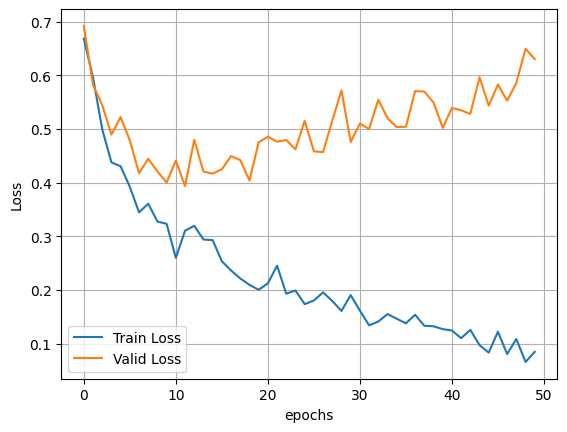

In [28]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

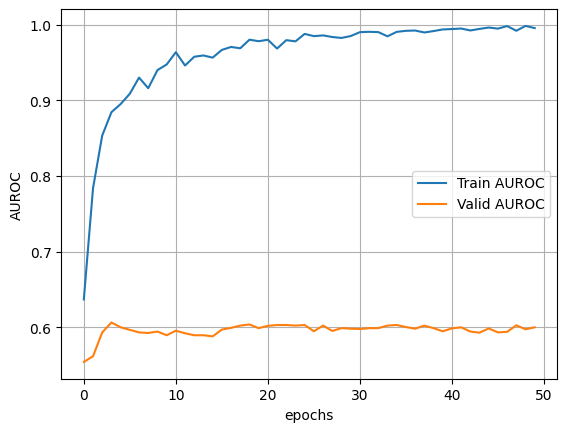

In [29]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

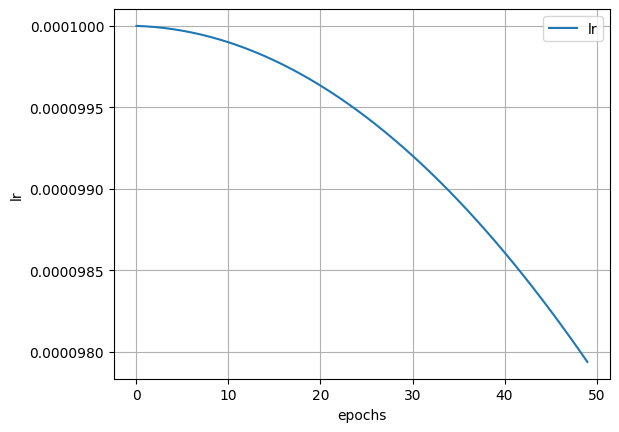

In [30]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()